In [5]:
# %% [markdown]
# # 番茄叶片病害数据探索与可视化
# 
# 本Notebook用于数据探索、统计分析和可视化

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random
from collections import Counter
import cv2
import gc
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# 设置样式
sns.set_style("whitegrid")
plt.style.use('seaborn-v0_8')

print("导入完成")

导入完成


In [7]:
# 添加项目根目录到路径
import sys
import os

# 获取当前notebook所在目录（notebooks文件夹）
current_dir = os.getcwd()  # 或者使用 os.path.dirname(os.path.abspath('.'))
print(f"当前目录: {current_dir}")

# 计算项目根目录（当前目录的父目录）
project_root = os.path.dirname(current_dir)
print(f"项目根目录: {project_root}")

# 添加项目根目录到Python路径
sys.path.insert(0, project_root)

# 检查路径是否正确添加
print(f"Python路径: {sys.path}")

# 现在尝试导入
try:
    from src.preprocess import check_dataset_structure
    print("成功导入预处理模块")
except ImportError as e:
    print(f"导入错误: {e}")
    print("尝试直接定义函数...")
    
    # 这里复制check_dataset_structure函数
    def check_dataset_structure(data_dir: str, max_classes_to_check: int = None):
        """检查数据集结构并返回有效的类别"""
        import os
        
        if not os.path.exists(data_dir):
            return False, f"路径 '{data_dir}' 不存在!"

        items = os.listdir(data_dir)
        class_folders = []

        if max_classes_to_check is not None:
            items_to_check = items[:max_classes_to_check]
        else:
            items_to_check = items

        for item in items_to_check:
            item_path = os.path.join(data_dir, item)
            if os.path.isdir(item_path):
                class_folders.append(item)

        if len(class_folders) == 0:
            return False, f"在 '{data_dir}' 中没有找到任何类别文件夹!"

        image_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tif', '.tiff', '.webp')
        valid_classes = []

        for class_name in class_folders:
            class_path = os.path.join(data_dir, class_name)
            file_count = 0

            try:
                all_files = os.listdir(class_path)
                for f in all_files:
                    if f.lower().endswith(image_extensions):
                        file_count += 1
            except Exception as e:
                print(f"检查类别 {class_name} 时出错: {e}")
                continue

            if file_count > 0:
                valid_classes.append((class_name, file_count))
                print(f"类别 '{class_name}' 有 {file_count} 张图片")
            else:
                print(f"警告: 类别 '{class_name}' 中没有找到图像文件!")

        if len(valid_classes) == 0:
            return False, f"在所有类别文件夹中都没有找到图像文件!"

        print(f"总共找到 {len(valid_classes)} 个有效类别")
        return True, valid_classes

当前目录: C:\Users\someb\Desktop\tomato_disease_classification\notebooks
项目根目录: C:\Users\someb\Desktop\tomato_disease_classification
Python路径: ['C:\\Users\\someb\\Desktop\\tomato_disease_classification', 'C:\\Users\\someb\\Desktop\\tomato_disease_classification', 'D:\\Anaconda\\envs\\tomato_project\\lib\\site-packages\\paddle\\base\\..\\libs', 'C:\\Users\\someb\\Desktop\\tomato_disease_classification', 'D:\\Anaconda\\envs\\tomato_project\\python39.zip', 'D:\\Anaconda\\envs\\tomato_project\\DLLs', 'D:\\Anaconda\\envs\\tomato_project\\lib', 'D:\\Anaconda\\envs\\tomato_project', '', 'D:\\Anaconda\\envs\\tomato_project\\lib\\site-packages', 'D:\\Anaconda\\envs\\tomato_project\\lib\\site-packages\\win32', 'D:\\Anaconda\\envs\\tomato_project\\lib\\site-packages\\win32\\lib', 'D:\\Anaconda\\envs\\tomato_project\\lib\\site-packages\\Pythonwin', 'D:\\Anaconda\\envs\\tomato_project\\lib\\site-packages\\setuptools\\_vendor']
成功导入预处理模块


In [8]:
# %% [markdown]
# ## 3. 检查数据集结构

# %%
# 设置数据集路径（请根据实际情况修改）
DATA_DIR = r"C:\Users\someb\Desktop\tomato_disease_classification\data\raw"


# %%
# 检查路径是否存在
if not os.path.exists(DATA_DIR):
    print(f"警告: 数据路径 '{DATA_DIR}' 不存在!")
    print("请创建一个示例目录结构:")
    print("DATA_DIR/")
    print("├── Healthy/")
    print("│   ├── image1.jpg")
    print("│   └── image2.jpg")
    print("├── Early_Blight/")
    print("│   ├── image1.jpg")
    print("│   └── image2.jpg")
    print("└── ...")
    
    # 创建示例路径
    DATA_DIR = "sample_data"
    os.makedirs(DATA_DIR, exist_ok=True)
    print(f"使用示例路径: {DATA_DIR}")
else:
    print(f"数据路径 '{DATA_DIR}' 存在")

# %%
# 检查数据集结构
is_valid, result = check_dataset_structure(DATA_DIR, max_classes_to_check=10)

if is_valid:
    valid_classes = result
    print(f"\n找到 {len(valid_classes)} 个有效类别:")
    
    # 转换为DataFrame以便分析
    class_df = pd.DataFrame(valid_classes, columns=['Class', 'Count'])
    print(f"\n类别统计:")
    print(class_df.sort_values('Count', ascending=False).to_string(index=False))
else:
    print(f"错误: {result}")

数据路径 'C:\Users\someb\Desktop\tomato_disease_classification\data\raw' 存在
类别 'Tomato_Bacterial_spot' 有 2127 张图片
类别 'Tomato_Early_blight' 有 1000 张图片
类别 'Tomato_healthy' 有 1591 张图片
类别 'Tomato_Late_blight' 有 1909 张图片
类别 'Tomato_Leaf_Mold' 有 952 张图片
类别 'Tomato_Septoria_leaf_spot' 有 1771 张图片
类别 'Tomato_Spider_mites_Two_spotted_spider_mite' 有 1676 张图片
类别 'Tomato__Target_Spot' 有 1404 张图片
类别 'Tomato__Tomato_mosaic_virus' 有 373 张图片
类别 'Tomato__Tomato_YellowLeaf__Curl_Virus' 有 3208 张图片
总共找到 10 个有效类别

找到 10 个有效类别:

类别统计:
                                      Class  Count
      Tomato__Tomato_YellowLeaf__Curl_Virus   3208
                      Tomato_Bacterial_spot   2127
                         Tomato_Late_blight   1909
                  Tomato_Septoria_leaf_spot   1771
Tomato_Spider_mites_Two_spotted_spider_mite   1676
                             Tomato_healthy   1591
                        Tomato__Target_Spot   1404
                        Tomato_Early_blight   1000
                           

In [9]:
if is_valid:
    # 详细统计分析
    class_df = pd.DataFrame(valid_classes, columns=['Class', 'Count'])
    
    print("=" * 60)
    print("数据集统计分析")
    print("=" * 60)
    
    total_images = class_df['Count'].sum()
    num_classes = len(class_df)
    
    print(f"总图片数: {total_images}")
    print(f"类别数: {num_classes}")
    print(f"平均每类图片数: {total_images/num_classes:.1f}")
    print(f"最大类别: {class_df.loc[class_df['Count'].idxmax(), 'Class']} ({class_df['Count'].max()}张)")
    print(f"最小类别: {class_df.loc[class_df['Count'].idxmin(), 'Class']} ({class_df['Count'].min()}张)")
    
    # 计算类别不平衡度
    mean_count = class_df['Count'].mean()
    std_count = class_df['Count'].std()
    imbalance_ratio = std_count / mean_count
    print(f"类别不平衡度 (标准差/均值): {imbalance_ratio:.3f}")
    
    # 统计信息
    print(f"\n详细统计:")
    print(class_df.describe())

数据集统计分析
总图片数: 16011
类别数: 10
平均每类图片数: 1601.1
最大类别: Tomato__Tomato_YellowLeaf__Curl_Virus (3208张)
最小类别: Tomato__Tomato_mosaic_virus (373张)
类别不平衡度 (标准差/均值): 0.480

详细统计:
             Count
count    10.000000
mean   1601.100000
std     768.679163
min     373.000000
25%    1101.000000
50%    1633.500000
75%    1874.500000
max    3208.000000


类别分布分析

<Figure size 1400x600 with 0 Axes>

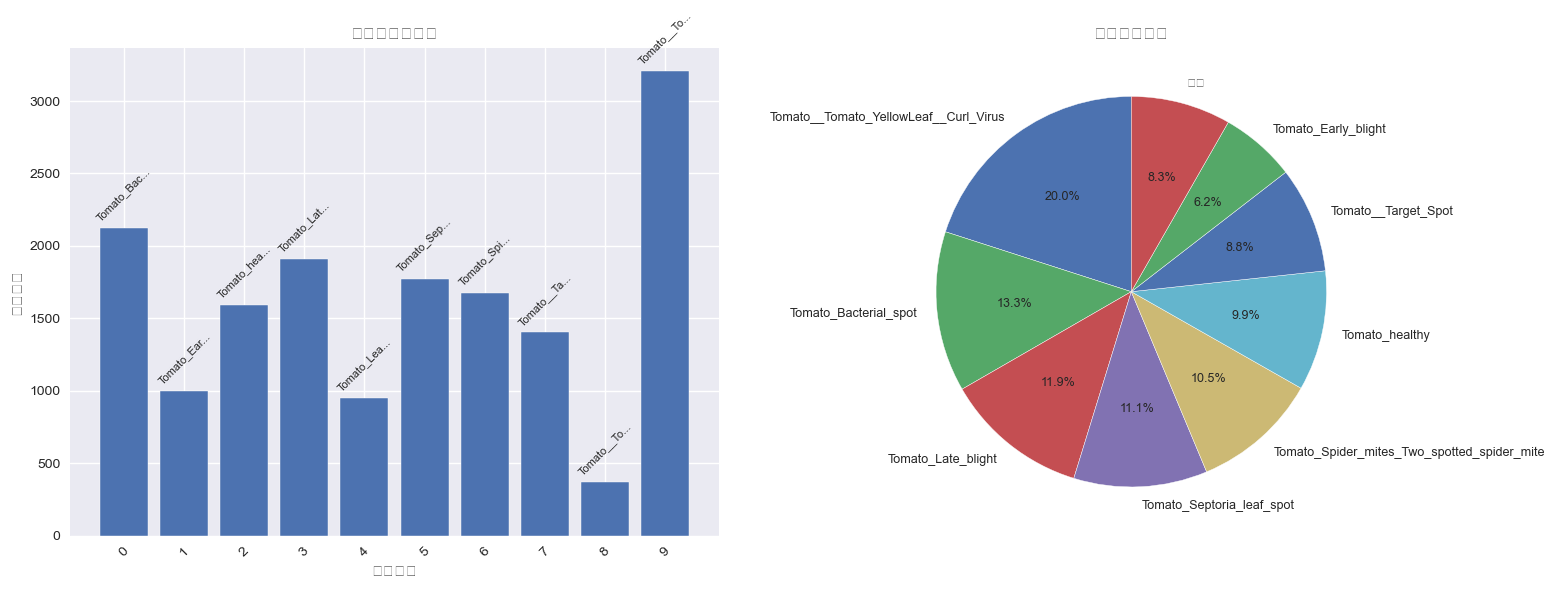

显示样本图片...


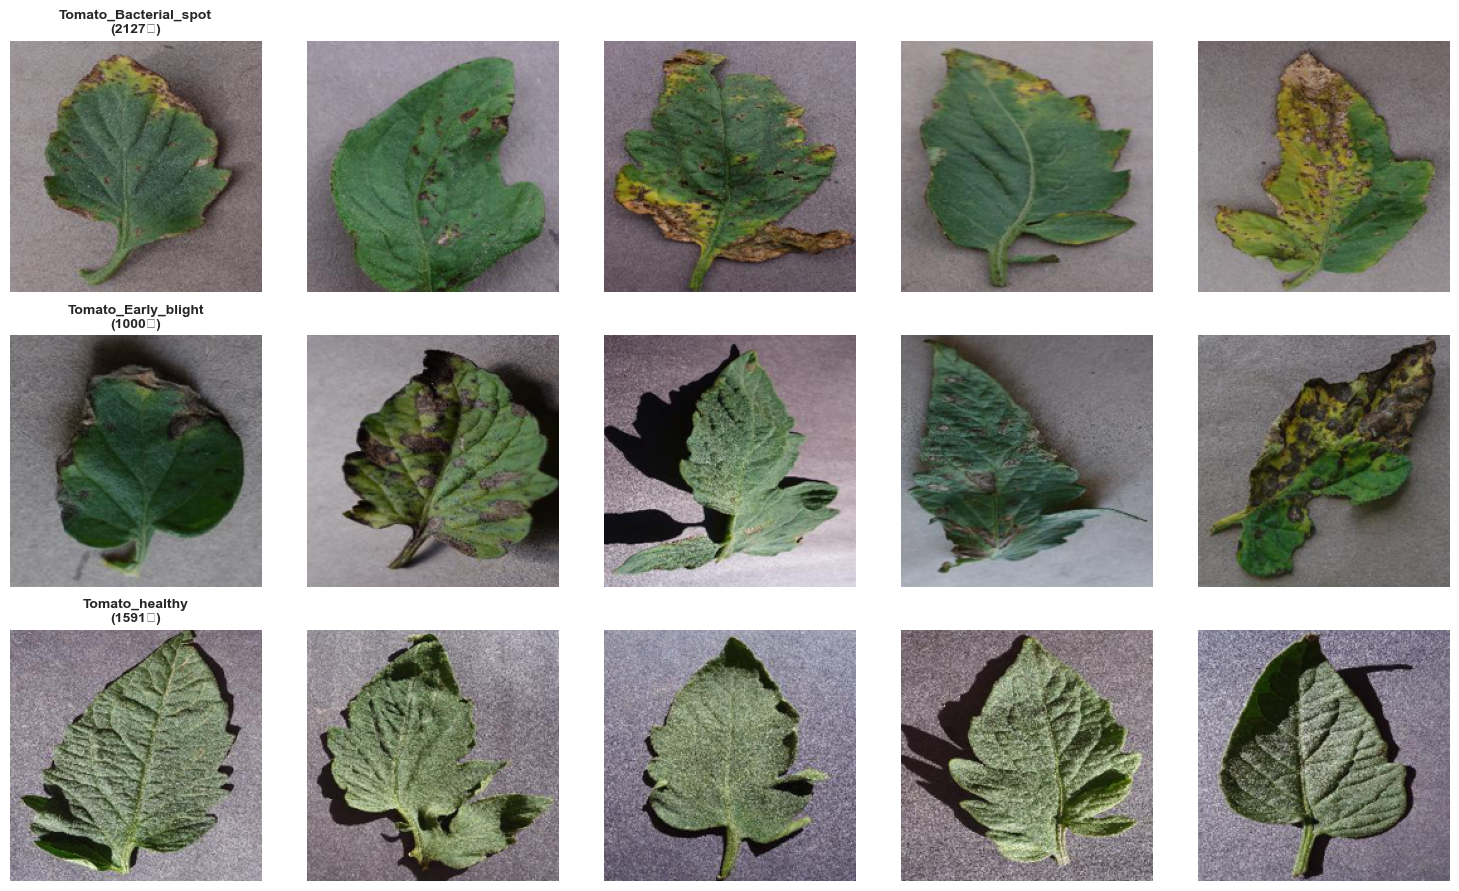

In [10]:
if is_valid:
    # 设置图形大小
    plt.figure(figsize=(14, 6))
    
    # 创建子图
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # 子图1: 条形图
    ax1 = axes[0]
    bars = ax1.bar(range(len(class_df)), class_df['Count'].values)
    ax1.set_xlabel('类别索引')
    ax1.set_ylabel('图片数量')
    ax1.set_title('类别分布条形图')
    ax1.set_xticks(range(len(class_df)))
    ax1.set_xticklabels(range(len(class_df)), rotation=45)
    
    # 为前10个类别添加标签
    for i, (idx, row) in enumerate(class_df.iterrows()):
        if i < 10:  # 只显示前10个类别名称
            ax1.text(i, row['Count'] + max(class_df['Count']) * 0.01, 
                    row['Class'][:10] + "...", 
                    ha='center', va='bottom', rotation=45, fontsize=8)
    
    # 子图2: 饼图（只显示前8个类别，其他合并为"其他"）
    ax2 = axes[1]
    if len(class_df) > 8:
        top_classes = class_df.nlargest(8, 'Count')
        other_count = total_images - top_classes['Count'].sum()
        pie_data = pd.concat([top_classes['Count'], pd.Series([other_count], index=['其他'])])
        pie_labels = list(top_classes['Class']) + ['其他']
    else:
        pie_data = class_df['Count']
        pie_labels = class_df['Class']
    
    wedges, texts, autotexts = ax2.pie(pie_data, labels=pie_labels, autopct='%1.1f%%',
                                       startangle=90, textprops={'fontsize': 9})
    ax2.set_title('类别分布饼图')
    
    plt.tight_layout()
    plt.show()


def display_sample_images(data_dir, classes=None, num_samples=5, max_display=3):
    """
    显示每个类别的样本图片
    
    Args:
        data_dir: 数据目录
        classes: 类别列表，如果为None则显示所有类别
        num_samples: 每个类别显示的样本数
        max_display: 最大显示类别数（避免太多图片）
    """
    if classes is None:
        # 获取所有类别
        classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    
    # 限制显示类别数
    display_classes = classes[:max_display]
    
    # 创建图形
    fig, axes = plt.subplots(len(display_classes), num_samples, 
                            figsize=(num_samples * 3, len(display_classes) * 3))
    
    if len(display_classes) == 1:
        axes = axes.reshape(1, -1)
    
    for i, class_name in enumerate(display_classes):
        class_path = os.path.join(data_dir, class_name)
        
        # 获取该类别所有图片
        image_files = []
        for f in os.listdir(class_path):
            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')):
                image_files.append(f)
        
        if len(image_files) == 0:
            print(f"警告: 类别 '{class_name}' 中没有图片")
            continue
        
        # 随机选择样本
        if len(image_files) > num_samples:
            sample_files = random.sample(image_files, num_samples)
        else:
            sample_files = image_files
        
        # 显示图片
        for j, img_file in enumerate(sample_files):
            img_path = os.path.join(class_path, img_file)
            
            try:
                # 读取图片
                img = Image.open(img_path)
                
                # 转换为RGB（如果是RGBA）
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                
                # 调整大小以便显示
                img_display = img.copy()
                img_display.thumbnail((200, 200))
                
                # 显示图片
                if len(display_classes) == 1:
                    ax = axes[j]
                else:
                    ax = axes[i, j]
                
                ax.imshow(img_display)
                ax.axis('off')
                
                # 只在第一行显示类别名称
                if j == 0:
                    ax.set_title(f"{class_name}\n({len(image_files)}张)", 
                                fontsize=10, fontweight='bold')
                
            except Exception as e:
                print(f"加载图片 {img_path} 时出错: {e}")
                # 显示黑色图片作为占位符
                if len(display_classes) == 1:
                    ax = axes[j]
                else:
                    ax = axes[i, j]
                ax.imshow(np.zeros((100, 100, 3), dtype=np.uint8))
                ax.axis('off')
                ax.set_title("加载失败", fontsize=8)
    
    plt.tight_layout()
    plt.show()

# %%
if is_valid:
    # 获取类别名称
    class_names = [c[0] for c in valid_classes]
    
    # 显示样本图片（限制显示前3个类别）
    print("显示样本图片...")
    display_sample_images(DATA_DIR, classes=class_names, num_samples=5, max_display=3)

图片属性分析

分析类别 'Tomato_Bacterial_spot' (30个样本)...


分析 Tomato_Bacterial_spot: 100%|█████████████████████████████████████████████████████| 30/30 [00:00<00:00, 471.81it/s]


分析类别 'Tomato_Early_blight' (30个样本)...


分析 Tomato_Early_blight: 100%|███████████████████████████████████████████████████████| 30/30 [00:00<00:00, 670.22it/s]


分析类别 'Tomato_healthy' (30个样本)...


分析 Tomato_healthy: 100%|████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 622.92it/s]


分析类别 'Tomato_Late_blight' (30个样本)...


分析 Tomato_Late_blight: 100%|████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 371.55it/s]


分析类别 'Tomato_Leaf_Mold' (30个样本)...


分析 Tomato_Leaf_Mold: 100%|██████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 645.47it/s]


分析类别 'Tomato_Septoria_leaf_spot' (30个样本)...


分析 Tomato_Septoria_leaf_spot: 100%|█████████████████████████████████████████████████| 30/30 [00:00<00:00, 692.51it/s]


分析类别 'Tomato_Spider_mites_Two_spotted_spider_mite' (30个样本)...


分析 Tomato_Spider_mites_Two_spotted_spider_mite: 100%|███████████████████████████████| 30/30 [00:00<00:00, 672.54it/s]


分析类别 'Tomato__Target_Spot' (30个样本)...


分析 Tomato__Target_Spot: 100%|███████████████████████████████████████████████████████| 30/30 [00:00<00:00, 665.65it/s]


分析类别 'Tomato__Tomato_mosaic_virus' (30个样本)...


分析 Tomato__Tomato_mosaic_virus: 100%|███████████████████████████████████████████████| 30/30 [00:00<00:00, 634.51it/s]


分析类别 'Tomato__Tomato_YellowLeaf__Curl_Virus' (30个样本)...


分析 Tomato__Tomato_YellowLeaf__Curl_Virus: 100%|█████████████████████████████████████| 30/30 [00:00<00:00, 709.96it/s]



图片属性统计分析
总样本数: 300

尺寸统计:
          宽度     高度       大小_KB
count  300.0  300.0  300.000000
mean   256.0  256.0   16.227113
std      0.0    0.0    4.427704
min    256.0  256.0    5.302734
25%    256.0  256.0   12.838623
50%    256.0  256.0   16.574707
75%    256.0  256.0   19.168213
max    256.0  256.0   27.005859

图片模式分布:
模式
RGB    300
Name: count, dtype: int64

图片格式分布:
格式
JPEG    300
Name: count, dtype: int64

宽高比统计:
平均宽高比: 1.00
最小宽高比: 1.00
最大宽高比: 1.00


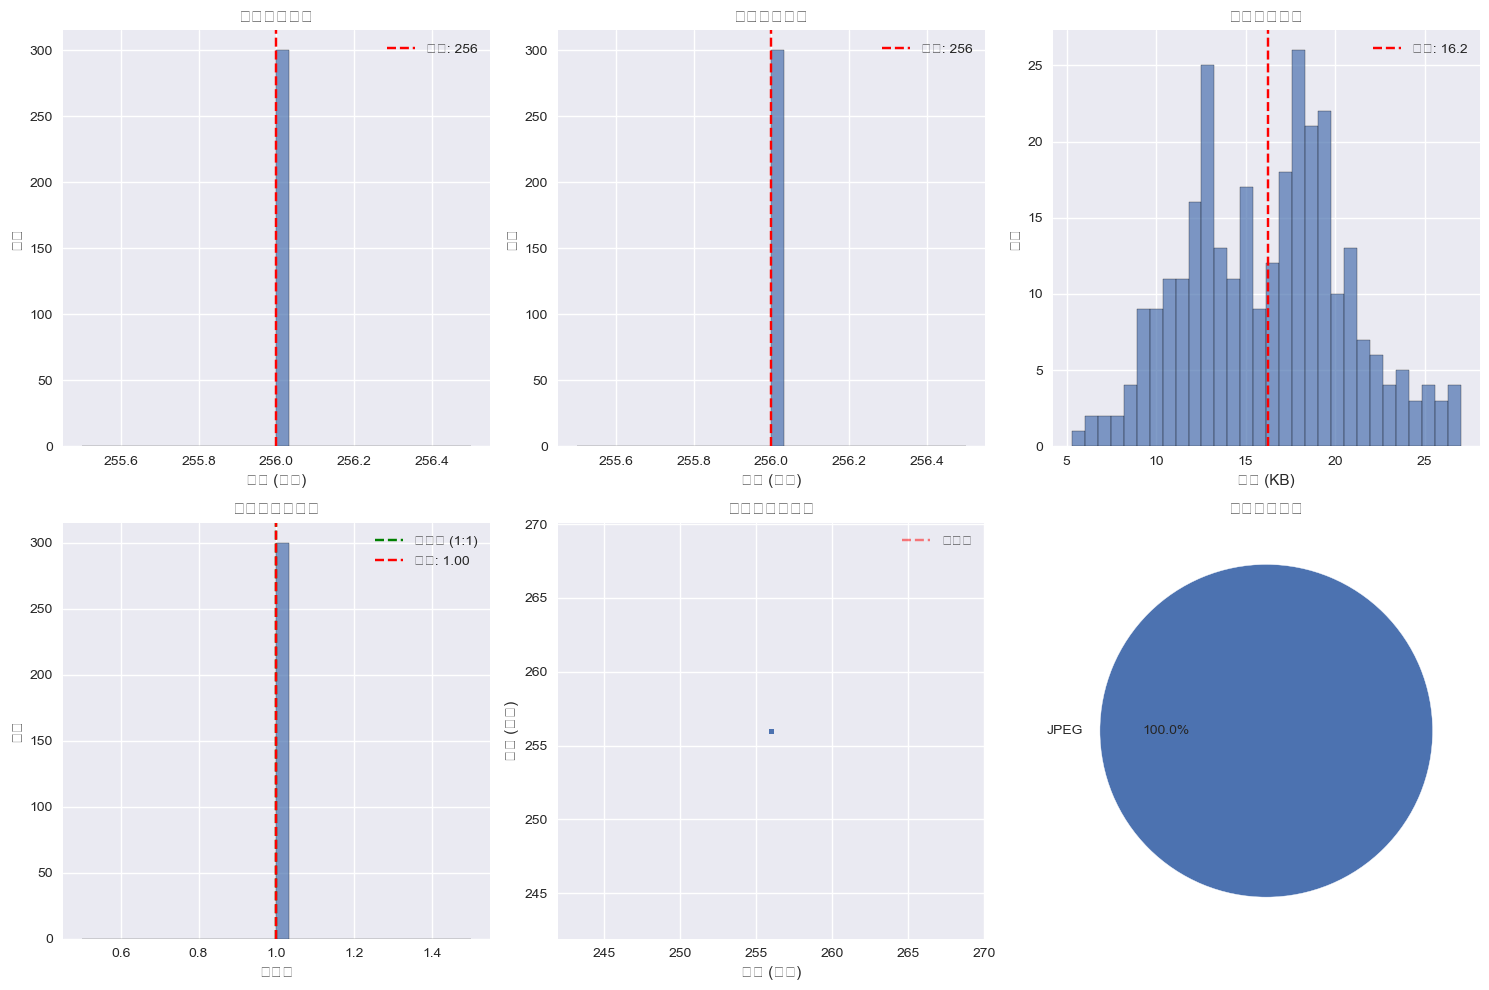

In [13]:
def analyze_image_properties(data_dir, sample_size=50):
    """
    分析图片的尺寸、通道等属性
    
    Args:
        data_dir: 数据目录
        sample_size: 每个类别分析的样本数
    """
    # 获取所有类别
    classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    
    # 存储统计信息
    widths = []
    heights = []
    modes = []
    sizes_kb = []
    formats = []
    
    # 对每个类别抽样分析
    for class_name in classes: 
        class_path = os.path.join(data_dir, class_name)
        
        # 获取图片文件
        image_files = []
        for f in os.listdir(class_path):
            if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                image_files.append(f)
        
        if len(image_files) == 0:
            continue
        
        # 抽样
        sample_files = random.sample(image_files, min(sample_size, len(image_files)))
        
        print(f"分析类别 '{class_name}' ({len(sample_files)}个样本)...")
        
        for img_file in tqdm(sample_files, desc=f"分析 {class_name}"):
            img_path = os.path.join(class_path, img_file)
            
            try:
                with Image.open(img_path) as img:
                    # 收集属性
                    widths.append(img.width)
                    heights.append(img.height)
                    modes.append(img.mode)
                    
                    # 获取文件大小
                    size_bytes = os.path.getsize(img_path)
                    sizes_kb.append(size_bytes / 1024)
                    
                    # 获取格式
                    formats.append(img.format)
                    
            except Exception as e:
                print(f"分析图片 {img_path} 时出错: {e}")
    
    # 创建统计DataFrame
    if widths:  # 确保有数据
        df_stats = pd.DataFrame({
            '宽度': widths,
            '高度': heights,
            '模式': modes,
            '大小_KB': sizes_kb,
            '格式': formats
        })
        
        # 计算宽高比
        df_stats['宽高比'] = df_stats['宽度'] / df_stats['高度']
        
        print("\n" + "=" * 60)
        print("图片属性统计分析")
        print("=" * 60)
        
        print(f"总样本数: {len(df_stats)}")
        print(f"\n尺寸统计:")
        print(df_stats[['宽度', '高度', '大小_KB']].describe())
        
        print(f"\n图片模式分布:")
        print(df_stats['模式'].value_counts())
        
        print(f"\n图片格式分布:")
        print(df_stats['格式'].value_counts())
        
        print(f"\n宽高比统计:")
        print(f"平均宽高比: {df_stats['宽高比'].mean():.2f}")
        print(f"最小宽高比: {df_stats['宽高比'].min():.2f}")
        print(f"最大宽高比: {df_stats['宽高比'].max():.2f}")
        
        return df_stats
    else:
        print("没有找到有效的图片进行分析")
        return None


if is_valid:
    # 分析图片属性
    df_stats = analyze_image_properties(DATA_DIR, sample_size=30)

if df_stats is not None:
    # 创建属性可视化
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # 1. 宽度分布
    axes[0, 0].hist(df_stats['宽度'], bins=30, edgecolor='black', alpha=0.7)
    axes[0, 0].set_xlabel('宽度 (像素)')
    axes[0, 0].set_ylabel('频率')
    axes[0, 0].set_title('图片宽度分布')
    axes[0, 0].axvline(df_stats['宽度'].mean(), color='red', linestyle='--', label=f"均值: {df_stats['宽度'].mean():.0f}")
    axes[0, 0].legend()
    
    # 2. 高度分布
    axes[0, 1].hist(df_stats['高度'], bins=30, edgecolor='black', alpha=0.7)
    axes[0, 1].set_xlabel('高度 (像素)')
    axes[0, 1].set_ylabel('频率')
    axes[0, 1].set_title('图片高度分布')
    axes[0, 1].axvline(df_stats['高度'].mean(), color='red', linestyle='--', label=f"均值: {df_stats['高度'].mean():.0f}")
    axes[0, 1].legend()
    
    # 3. 大小分布
    axes[0, 2].hist(df_stats['大小_KB'], bins=30, edgecolor='black', alpha=0.7)
    axes[0, 2].set_xlabel('大小 (KB)')
    axes[0, 2].set_ylabel('频率')
    axes[0, 2].set_title('图片大小分布')
    axes[0, 2].axvline(df_stats['大小_KB'].mean(), color='red', linestyle='--', label=f"均值: {df_stats['大小_KB'].mean():.1f}")
    axes[0, 2].legend()
    
    # 4. 宽高比分布
    axes[1, 0].hist(df_stats['宽高比'], bins=30, edgecolor='black', alpha=0.7)
    axes[1, 0].set_xlabel('宽高比')
    axes[1, 0].set_ylabel('频率')
    axes[1, 0].set_title('图片宽高比分布')
    axes[1, 0].axvline(1.0, color='green', linestyle='--', label='正方形 (1:1)')
    axes[1, 0].axvline(df_stats['宽高比'].mean(), color='red', linestyle='--', label=f"均值: {df_stats['宽高比'].mean():.2f}")
    axes[1, 0].legend()
    
    # 5. 散点图：宽度 vs 高度
    axes[1, 1].scatter(df_stats['宽度'], df_stats['高度'], alpha=0.5, s=10)
    axes[1, 1].set_xlabel('宽度 (像素)')
    axes[1, 1].set_ylabel('高度 (像素)')
    axes[1, 1].set_title('图片尺寸散点图')
    
    # 添加对角线（正方形参考线）
    min_size = min(df_stats['宽度'].min(), df_stats['高度'].min())
    max_size = max(df_stats['宽度'].max(), df_stats['高度'].max())
    axes[1, 1].plot([min_size, max_size], [min_size, max_size], 'r--', alpha=0.5, label='正方形')
    axes[1, 1].legend()
    
    # 6. 格式分布饼图
    format_counts = df_stats['格式'].value_counts()
    axes[1, 2].pie(format_counts.values, labels=format_counts.index, autopct='%1.1f%%')
    axes[1, 2].set_title('图片格式分布')
    
    plt.tight_layout()
    plt.show()

颜色分布分析

分析类别 'Tomato_Bacterial_spot' 的颜色分布...


颜色分析 Tomato_Bacterial_spot: 100%|█████████████████████████████████████████████████| 15/15 [00:00<00:00, 189.71it/s]


分析类别 'Tomato_Early_blight' 的颜色分布...


颜色分析 Tomato_Early_blight: 100%|███████████████████████████████████████████████████| 15/15 [00:00<00:00, 150.89it/s]


分析类别 'Tomato_healthy' 的颜色分布...


颜色分析 Tomato_healthy: 100%|████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 177.76it/s]


分析类别 'Tomato_Late_blight' 的颜色分布...


颜色分析 Tomato_Late_blight: 100%|████████████████████████████████████████████████████| 15/15 [00:00<00:00, 193.50it/s]


分析类别 'Tomato_Leaf_Mold' 的颜色分布...


颜色分析 Tomato_Leaf_Mold: 100%|██████████████████████████████████████████████████████| 15/15 [00:00<00:00, 201.60it/s]


分析类别 'Tomato_Septoria_leaf_spot' 的颜色分布...


颜色分析 Tomato_Septoria_leaf_spot: 100%|█████████████████████████████████████████████| 15/15 [00:00<00:00, 315.33it/s]


分析类别 'Tomato_Spider_mites_Two_spotted_spider_mite' 的颜色分布...


颜色分析 Tomato_Spider_mites_Two_spotted_spider_mite: 100%|███████████████████████████| 15/15 [00:00<00:00, 344.84it/s]


分析类别 'Tomato__Target_Spot' 的颜色分布...


颜色分析 Tomato__Target_Spot: 100%|███████████████████████████████████████████████████| 15/15 [00:00<00:00, 364.24it/s]


分析类别 'Tomato__Tomato_mosaic_virus' 的颜色分布...


颜色分析 Tomato__Tomato_mosaic_virus: 100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 365.72it/s]


分析类别 'Tomato__Tomato_YellowLeaf__Curl_Virus' 的颜色分布...


颜色分析 Tomato__Tomato_YellowLeaf__Curl_Virus: 100%|█████████████████████████████████| 15/15 [00:00<00:00, 341.58it/s]



颜色分析完成，共分析 150 张图片


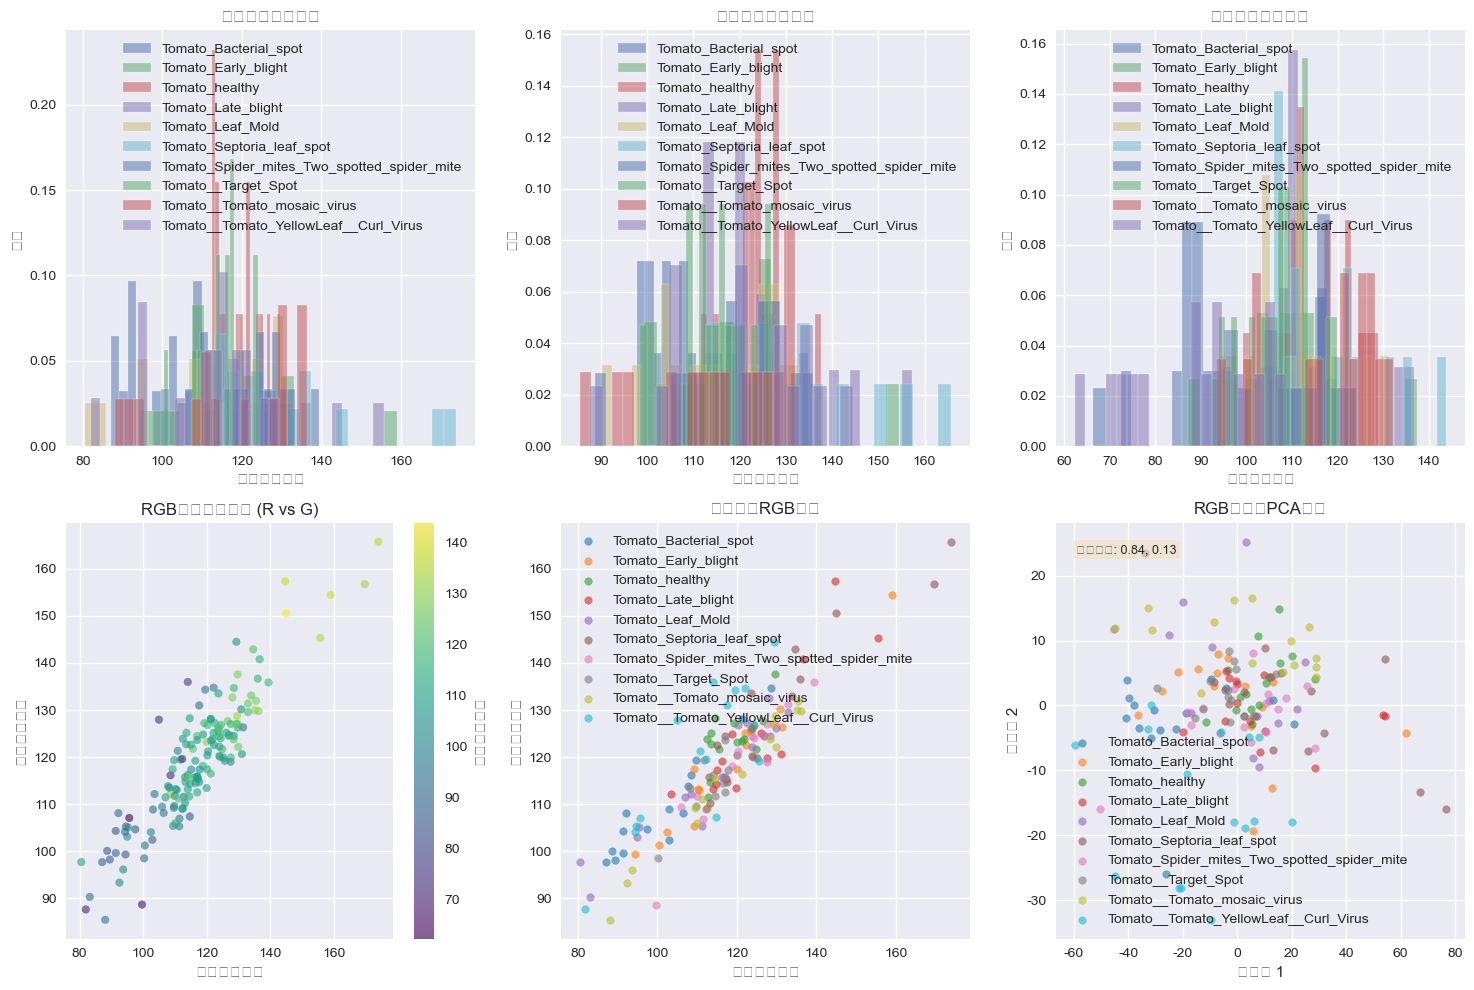

In [15]:
def analyze_color_distribution(data_dir, sample_per_class=20):
    """
    分析图片的颜色分布
    
    Args:
        data_dir: 数据目录
        sample_per_class: 每个类别分析的样本数
    """
    # 获取所有类别
    classes = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    
   
    
    # 存储颜色统计
    color_stats = []
    
    for class_name in classes:
        class_path = os.path.join(data_dir, class_name)
        
        # 获取图片文件
        image_files = []
        for f in os.listdir(class_path):
            if f.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_files.append(f)
        
        if len(image_files) == 0:
            continue
        
        # 抽样
        sample_files = random.sample(image_files, min(sample_per_class, len(image_files)))
        
        print(f"分析类别 '{class_name}' 的颜色分布...")
        
        for img_file in tqdm(sample_files, desc=f"颜色分析 {class_name}"):
            img_path = os.path.join(class_path, img_file)
            
            try:
                # 使用OpenCV读取图片
                img = cv2.imread(img_path)
                if img is None:
                    continue
                
                # 转换为RGB
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
                # 计算每个通道的均值
                mean_r = np.mean(img_rgb[:, :, 0])
                mean_g = np.mean(img_rgb[:, :, 1])
                mean_b = np.mean(img_rgb[:, :, 2])
                
                # 计算每个通道的标准差
                std_r = np.std(img_rgb[:, :, 0])
                std_g = np.std(img_rgb[:, :, 1])
                std_b = np.std(img_rgb[:, :, 2])
                
                color_stats.append({
                    'class': class_name,
                    'mean_r': mean_r,
                    'mean_g': mean_g,
                    'mean_b': mean_b,
                    'std_r': std_r,
                    'std_g': std_g,
                    'std_b': std_b
                })
                
            except Exception as e:
                print(f"分析图片 {img_path} 时出错: {e}")
    
    if color_stats:
        df_color = pd.DataFrame(color_stats)
        
        print(f"\n颜色分析完成，共分析 {len(df_color)} 张图片")
        return df_color
    else:
        print("没有找到有效的图片进行颜色分析")
        return None

# %%
if is_valid:
    # 分析颜色分布
    df_color = analyze_color_distribution(DATA_DIR, sample_per_class=15)

if df_color is not None:
    # 创建颜色分布可视化
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # 获取类别列表
    classes = df_color['class'].unique()
    
    # 1. 红色通道均值分布
    for i, cls in enumerate(classes):
        class_data = df_color[df_color['class'] == cls]
        axes[0, 0].hist(class_data['mean_r'], bins=20, alpha=0.5, label=cls, density=True)
    axes[0, 0].set_xlabel('红色通道均值')
    axes[0, 0].set_ylabel('密度')
    axes[0, 0].set_title('红色通道均值分布')
    axes[0, 0].legend()
    
    # 2. 绿色通道均值分布
    for i, cls in enumerate(classes):
        class_data = df_color[df_color['class'] == cls]
        axes[0, 1].hist(class_data['mean_g'], bins=20, alpha=0.5, label=cls, density=True)
    axes[0, 1].set_xlabel('绿色通道均值')
    axes[0, 1].set_ylabel('密度')
    axes[0, 1].set_title('绿色通道均值分布')
    axes[0, 1].legend()
    
    # 3. 蓝色通道均值分布
    for i, cls in enumerate(classes):
        class_data = df_color[df_color['class'] == cls]
        axes[0, 2].hist(class_data['mean_b'], bins=20, alpha=0.5, label=cls, density=True)
    axes[0, 2].set_xlabel('蓝色通道均值')
    axes[0, 2].set_ylabel('密度')
    axes[0, 2].set_title('蓝色通道均值分布')
    axes[0, 2].legend()
    
    # 4. RGB均值散点图（2D投影）
    scatter = axes[1, 0].scatter(df_color['mean_r'], df_color['mean_g'], 
                                 c=df_color['mean_b'], alpha=0.6, s=30, cmap='viridis')
    axes[1, 0].set_xlabel('红色通道均值')
    axes[1, 0].set_ylabel('绿色通道均值')
    axes[1, 0].set_title('RGB颜色空间分布 (R vs G)')
    plt.colorbar(scatter, ax=axes[1, 0], label='蓝色通道均值')
    
    # 5. 按类别着色的RGB散点图
    colors = plt.cm.tab10(np.linspace(0, 1, len(classes)))
    for i, cls in enumerate(classes):
        class_data = df_color[df_color['class'] == cls]
        axes[1, 1].scatter(class_data['mean_r'], class_data['mean_g'], 
                          color=colors[i], alpha=0.6, s=30, label=cls)
    axes[1, 1].set_xlabel('红色通道均值')
    axes[1, 1].set_ylabel('绿色通道均值')
    axes[1, 1].set_title('按类别的RGB分布')
    axes[1, 1].legend()
    
    # 6. 3D RGB分布（使用2D投影）
    # 创建2D投影：主成分分析
    from sklearn.decomposition import PCA
    
    rgb_data = df_color[['mean_r', 'mean_g', 'mean_b']].values
    
    if len(rgb_data) > 1:
        pca = PCA(n_components=2)
        rgb_pca = pca.fit_transform(rgb_data)
        
        # 按类别着色
        for i, cls in enumerate(classes):
            class_mask = df_color['class'] == cls
            axes[1, 2].scatter(rgb_pca[class_mask, 0], rgb_pca[class_mask, 1], 
                              color=colors[i], alpha=0.6, s=30, label=cls)
        
        axes[1, 2].set_xlabel('主成分 1')
        axes[1, 2].set_ylabel('主成分 2')
        axes[1, 2].set_title('RGB空间的PCA投影')
        axes[1, 2].legend()
        
        # 显示解释方差比
        var_ratio = pca.explained_variance_ratio_
        axes[1, 2].text(0.05, 0.95, f"解释方差: {var_ratio[0]:.2f}, {var_ratio[1]:.2f}", 
                       transform=axes[1, 2].transAxes, fontsize=9,
                       verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()

数据集划分建议

In [16]:
if is_valid:
    # 基于分析结果给出数据集划分建议
    class_df = pd.DataFrame(valid_classes, columns=['Class', 'Count'])
    
    print("=" * 60)
    print("数据集划分建议")
    print("=" * 60)
    
    total_images = class_df['Count'].sum()
    
    # 建议的划分比例
    train_ratio = 0.7
    val_ratio = 0.15
    test_ratio = 0.15
    
    print(f"建议划分比例:")
    print(f"  训练集: {train_ratio*100:.0f}%")
    print(f"  验证集: {val_ratio*100:.0f}%")
    print(f"  测试集: {test_ratio*100:.0f}%")
    print()
    
    print("各类别建议划分数量:")
    print("-" * 60)
    print(f"{'类别':<20} {'总数':<8} {'训练集':<8} {'验证集':<8} {'测试集':<8}")
    print("-" * 60)
    
    for _, row in class_df.iterrows():
        class_name = row['Class']
        count = row['Count']
        
        train_count = int(count * train_ratio)
        val_count = int(count * val_ratio)
        test_count = count - train_count - val_count
        
        print(f"{class_name:<20} {count:<8} {train_count:<8} {val_count:<8} {test_count:<8}")
    
    print("-" * 60)
    
    total_train = int(total_images * train_ratio)
    total_val = int(total_images * val_ratio)
    total_test = total_images - total_train - total_val
    
    print(f"{'总计':<20} {total_images:<8} {total_train:<8} {total_val:<8} {total_test:<8}")
    
    # 检查最小类别是否足够划分
    min_count = class_df['Count'].min()
    min_train = int(min_count * train_ratio)
    
    if min_train < 5:
        print(f"\n警告: 最小类别 '{class_df.loc[class_df['Count'].idxmin(), 'Class']}' 的训练样本可能不足 ({min_train}张)")
        print("建议:")
        print("  1. 收集更多数据")
        print("  2. 使用过采样技术")
        print("  3. 使用数据增强")
        print("  4. 调整划分比例 (如 80/10/10)")
    
    # 检查类别不平衡
    imbalance_threshold = 5.0  # 最大类别与最小类别的比例阈值
    max_min_ratio = class_df['Count'].max() / class_df['Count'].min()
    
    if max_min_ratio > imbalance_threshold:
        print(f"\n警告: 检测到严重的类别不平衡 (最大/最小 = {max_min_ratio:.1f})")
        print("建议:")
        print("  1. 对少数类别进行过采样")
        print("  2. 对多数类别进行欠采样")
        print("  3. 使用类别权重")
        print("  4. 使用Focal Loss等不平衡损失函数")

数据集划分建议
建议划分比例:
  训练集: 70%
  验证集: 15%
  测试集: 15%

各类别建议划分数量:
------------------------------------------------------------
类别                   总数       训练集      验证集      测试集     
------------------------------------------------------------
Tomato_Bacterial_spot 2127     1488     319      320     
Tomato_Early_blight  1000     700      150      150     
Tomato_healthy       1591     1113     238      240     
Tomato_Late_blight   1909     1336     286      287     
Tomato_Leaf_Mold     952      666      142      144     
Tomato_Septoria_leaf_spot 1771     1239     265      267     
Tomato_Spider_mites_Two_spotted_spider_mite 1676     1173     251      252     
Tomato__Target_Spot  1404     982      210      212     
Tomato__Tomato_mosaic_virus 373      261      55       57      
Tomato__Tomato_YellowLeaf__Curl_Virus 3208     2245     481      482     
------------------------------------------------------------
总计                   16011    11207    2401     2403    

警告: 检测到严重的类别不平衡 (最

数据探索总结

In [17]:
if is_valid:
    print("=" * 60)
    print("数据探索总结")
    print("=" * 60)
    
    # 基本统计
    total_images = class_df['Count'].sum()
    num_classes = len(class_df)
    
    print(f"1. 数据集规模:")
    print(f"   - 总图片数: {total_images}")
    print(f"   - 类别数: {num_classes}")
    print(f"   - 平均每类图片数: {total_images/num_classes:.1f}")
    
    print(f"\n2. 类别分布:")
    print(f"   - 最大类别: {class_df['Count'].max()}张")
    print(f"   - 最小类别: {class_df['Count'].min()}张")
    print(f"   - 不平衡度: {class_df['Count'].std()/class_df['Count'].mean():.3f}")
    
    print(f"\n3. 建议:")
    print(f"   - 划分比例: 70% 训练, 15% 验证, 15% 测试")
    print(f"   - 图像尺寸: 统一调整为224x224或256x256")
    print(f"   - 数据增强: 使用旋转、翻转、颜色抖动等")
    
    if 'df_stats' in locals() and df_stats is not None:
        print(f"\n4. 图像属性:")
        print(f"   - 平均尺寸: {df_stats['宽度'].mean():.0f}x{df_stats['高度'].mean():.0f}")
        print(f"   - 平均大小: {df_stats['大小_KB'].mean():.1f} KB")
        print(f"   - 主要格式: {df_stats['格式'].mode()[0]}")
    
    print(f"\n5. 下一步:")
    print(f"   - 运行数据划分脚本: python split_dataset.py")
    print(f"   - 进行数据预处理和增强")
    print(f"   - 训练基线模型")

数据探索总结
1. 数据集规模:
   - 总图片数: 16011
   - 类别数: 10
   - 平均每类图片数: 1601.1

2. 类别分布:
   - 最大类别: 3208张
   - 最小类别: 373张
   - 不平衡度: 0.480

3. 建议:
   - 划分比例: 70% 训练, 15% 验证, 15% 测试
   - 图像尺寸: 统一调整为224x224或256x256
   - 数据增强: 使用旋转、翻转、颜色抖动等

4. 图像属性:
   - 平均尺寸: 256x256
   - 平均大小: 16.2 KB
   - 主要格式: JPEG

5. 下一步:
   - 运行数据划分脚本: python split_dataset.py
   - 进行数据预处理和增强
   - 训练基线模型


保存分析结果

In [18]:
if is_valid:
    # 创建输出目录
    output_dir = "data_exploration_results"
    os.makedirs(output_dir, exist_ok=True)
    
    # 保存类别统计
    class_df.to_csv(os.path.join(output_dir, "class_statistics.csv"), index=False, encoding='utf-8')
    
    # 保存图片属性统计（如果有）
    if 'df_stats' in locals() and df_stats is not None:
        df_stats.to_csv(os.path.join(output_dir, "image_properties.csv"), index=False, encoding='utf-8')
    
    # 保存颜色统计（如果有）
    if 'df_color' in locals() and df_color is not None:
        df_color.to_csv(os.path.join(output_dir, "color_statistics.csv"), index=False, encoding='utf-8')
    
    # 保存总结报告
    with open(os.path.join(output_dir, "summary.txt"), 'w', encoding='utf-8') as f:
        f.write("番茄叶片病害数据探索总结\n")
        f.write("=" * 60 + "\n\n")
        f.write(f"数据集路径: {DATA_DIR}\n")
        f.write(f"分析时间: {pd.Timestamp.now()}\n\n")
        
        f.write("1. 基本统计:\n")
        f.write(f"   总图片数: {total_images}\n")
        f.write(f"   类别数: {num_classes}\n")
        f.write(f"   平均每类图片数: {total_images/num_classes:.1f}\n\n")
        
        f.write("2. 类别分布:\n")
        for _, row in class_df.iterrows():
            f.write(f"   {row['Class']}: {row['Count']}张 ({row['Count']/total_images*100:.1f}%)\n")
        
        if 'df_stats' in locals() and df_stats is not None:
            f.write(f"\n3. 图像属性:\n")
            f.write(f"   平均宽度: {df_stats['宽度'].mean():.0f}像素\n")
            f.write(f"   平均高度: {df_stats['高度'].mean():.0f}像素\n")
            f.write(f"   平均大小: {df_stats['大小_KB'].mean():.1f} KB\n")
            f.write(f"   主要格式: {df_stats['格式'].mode()[0]}\n")
        
        f.write(f"\n4. 建议:\n")
        f.write(f"   - 划分比例: 70%训练, 15%验证, 15%测试\n")
        f.write(f"   - 图像尺寸: 统一为224x224\n")
        f.write(f"   - 数据增强: 旋转、翻转、颜色调整\n")
        
        if max_min_ratio > 5.0:
            f.write(f"   - 注意: 检测到类别不平衡，建议使用过采样/欠采样\n")
    
    print(f"\n分析结果已保存到: {output_dir}/")
    print(f"  1. class_statistics.csv - 类别统计")
    if 'df_stats' in locals() and df_stats is not None:
        print(f"  2. image_properties.csv - 图片属性")
    if 'df_color' in locals() and df_color is not None:
        print(f"  3. color_statistics.csv - 颜色统计")
    print(f"  4. summary.txt - 总结报告")

print("\n数据探索完成!")


分析结果已保存到: data_exploration_results/
  1. class_statistics.csv - 类别统计
  2. image_properties.csv - 图片属性
  3. color_statistics.csv - 颜色统计
  4. summary.txt - 总结报告

数据探索完成!
